In [ ]:
# Nguyen Hai Duong
# nhduong_3010@live.com
# Chonnam National University
# 2018.03.28
# based on https://github.com/imlab-uiip/keras-segnet

# Overview
- SegNet for image segmentation
- Input: depth image (acquired via Kinect camera)
- Output: hand components

# Import libraries

In [2]:
from keras import models
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Reshape, Permute
from keras.optimizers import Adam

import os, time, numpy as np, matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
n_classes = 7
kernel = 3
img_h = img_w = 96

# (1) Data

#### Hand images: https://drive.google.com/open?id=1MRiBnDW9dE7mNb5bL-jzhmtTd2CSklvL

In [4]:
def prepare_segnet_data(root_path):
    loi = os.listdir(root_path)

    data_x = np.zeros((int(len(loi)), img_h, img_w, 1))
    data_y = np.zeros((int(len(loi)), img_h, img_w, n_classes), dtype=np.uint8)

    for im_ind, fn in enumerate(loi):
        def gray2classes(label_img, img_h=96, img_w=96, n_classes=7):
            label_img_oh = np.zeros((img_h, img_w, n_classes), dtype=np.uint8)

            def get_oh(label_img, class_color):
                oh_tmp = np.zeros((img_h, img_w), dtype=np.uint8)
                oh_tmp[np.where(label_img == class_color)] = 1
                return oh_tmp

            # palm
            class_color = 255
            class_indx = 0
            label_img_oh[:, :, class_indx] = get_oh(label_img, class_color)

            # finger 1
            class_color = 43
            class_indx = 1
            label_img_oh[:, :, class_indx] = get_oh(label_img, class_color)

            # finger 2
            class_color = 85
            class_indx = 2
            label_img_oh[:, :, class_indx] = get_oh(label_img, class_color)

            # finger 3
            class_color = 128
            class_indx = 3
            label_img_oh[:, :, class_indx] = get_oh(label_img, class_color)

            # finger 4
            class_color = 170
            class_indx = 4
            label_img_oh[:, :, class_indx] = get_oh(label_img, class_color)

            # finger 5
            class_color = 212
            class_indx = 5
            label_img_oh[:, :, class_indx] = get_oh(label_img, class_color)

            # background
            class_color = 0
            class_indx = 6
            label_img_oh[:, :, class_indx] = get_oh(label_img, class_color)

            return label_img_oh

        fn = os.path.join(root_path, fn)
        labels_fn = fn.replace('depth', 'labels')

        img = np.uint8(resize(imread(fn), (img_h, img_w), order=0, mode='constant', preserve_range=True))
        img = np.expand_dims(img, axis=2)

        label = gray2classes(np.uint8(resize(imread(labels_fn), (img_h, img_w), order=0, mode='constant', preserve_range=True)), img_h=img_h, img_w=img_w, n_classes=n_classes)

        data_x[im_ind, :, :, :] = img
        data_y[im_ind, :, :, :] = label

    data_y = data_y.reshape((int(len(loi)), img_h * img_w, n_classes))

    return data_x, data_y

In [5]:
root_path = './data/segnet/train/depth'
x_train, y_train = prepare_segnet_data(root_path)

root_path = './data/segnet/test/depth'
x_test, y_test = prepare_segnet_data(root_path)

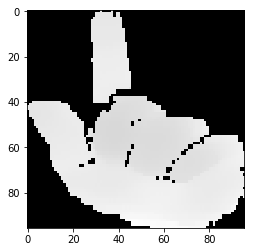

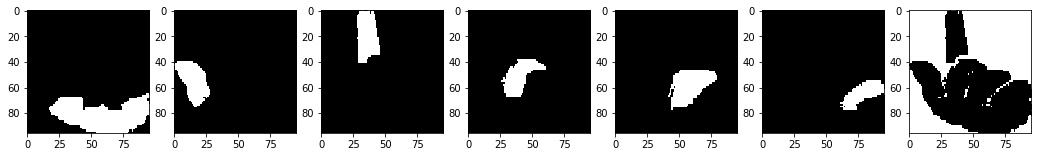

In [6]:
plt.imshow(x_test[1000, :, :, 0], cmap='gray')
plt.show()

plt.figure(figsize=(18, 5))
fin_ind = 1
plt.subplot(1, 7, fin_ind)
plt.imshow(y_test[1000, :, fin_ind - 1].reshape(img_h, img_w), cmap='gray')
fin_ind = 2
plt.subplot(1, 7, fin_ind)
plt.imshow(y_test[1000, :, fin_ind - 1].reshape(img_h, img_w), cmap='gray')
fin_ind = 3
plt.subplot(1, 7, fin_ind)
plt.imshow(y_test[1000, :, fin_ind - 1].reshape(img_h, img_w), cmap='gray')
fin_ind = 4
plt.subplot(1, 7, fin_ind)
plt.imshow(y_test[1000, :, fin_ind - 1].reshape(img_h, img_w), cmap='gray')
fin_ind = 5
plt.subplot(1, 7, fin_ind)
plt.imshow(y_test[1000, :, fin_ind - 1].reshape(img_h, img_w), cmap='gray')
fin_ind = 6
plt.subplot(1, 7, fin_ind)
plt.imshow(y_test[1000, :, fin_ind - 1].reshape(img_h, img_w), cmap='gray')
fin_ind = 7
plt.subplot(1, 7, fin_ind)
plt.imshow(y_test[1000, :, fin_ind - 1].reshape(img_h, img_w), cmap='gray')
plt.show()

# (2) Declare model

In [45]:
encoding_layers = [
    Conv2D(64, (kernel, kernel), padding='same', input_shape=(img_h, img_w, 1)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
]

autoencoder = models.Sequential()
autoencoder.encoding_layers = encoding_layers

for l in autoencoder.encoding_layers:
    autoencoder.add(l)

decoding_layers = [
    UpSampling2D(),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(64, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(n_classes, (1, 1), padding='valid'),
    BatchNormalization(),
]
autoencoder.decoding_layers = decoding_layers
for l in autoencoder.decoding_layers:
    autoencoder.add(l)

autoencoder.add(Reshape((n_classes, img_h * img_w)))
autoencoder.add(Permute((2, 1)))
autoencoder.add(Activation('softmax'))

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 96, 96, 64)        640       
_________________________________________________________________
batch_normalization_27 (Batc (None, 96, 96, 64)        256       
_________________________________________________________________
activation_27 (Activation)   (None, 96, 96, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 96, 96, 64)        36928     
_________________________________________________________________
batch_normalization_28 (Batc (None, 96, 96, 64)        256       
_________________________________________________________________
activation_28 (Activation)   (None, 96, 96, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 48, 48, 64)        0         
__________

# (3) Train defined model
- In case your system runs out of memory (OOM), try to use smaller batch size

In [46]:
lr = 0.0001
batch_size = 8
nb_epoch = 15

optimizer = Adam(lr=lr)
autoencoder.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

start_time = time.time()

autoencoder.fit(x_train, y_train,
                validation_data=(x_test, y_test),
                batch_size=batch_size, epochs=nb_epoch,
                verbose=1)

training_time = time.time() - start_time
print('> training time: ' + str(training_time) + 's')

Train on 2450 samples, validate on 1050 samples
Epoch 1/15
2450/2450 [==============================] - 57s 23ms/step - loss: 1.0994 - acc: 0.6314 - val_loss: 1.1558 - val_acc: 0.6190
Epoch 2/15
2450/2450 [==============================] - 49s 20ms/step - loss: 0.8320 - acc: 0.7357 - val_loss: 0.9133 - val_acc: 0.6965
Epoch 3/15
2450/2450 [==============================] - 49s 20ms/step - loss: 0.7114 - acc: 0.7862 - val_loss: 0.8201 - val_acc: 0.7284
Epoch 4/15
2450/2450 [==============================] - 49s 20ms/step - loss: 0.6346 - acc: 0.8162 - val_loss: 0.7919 - val_acc: 0.7376
Epoch 5/15
2450/2450 [==============================] - 49s 20ms/step - loss: 0.5755 - acc: 0.8391 - val_loss: 0.7591 - val_acc: 0.7599
Epoch 6/15
2450/2450 [==============================] - 49s 20ms/step - loss: 0.5362 - acc: 0.8518 - val_loss: 0.7387 - val_acc: 0.7645
Epoch 7/15
2450/2450 [==============================] - 49s 20ms/step - loss: 0.4995 - acc: 0.8636 - val_loss: 0.7341 - val_acc: 0.7624


# (4) Evaluate trained model

In [47]:
score = autoencoder.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1050/1050 [==============================] - 3s 3ms/step
Test loss: 0.6860425207728431
Test accuracy: 0.7732082881246294


In [48]:
def class_to_rgb(output_dis):
    rgb_out = np.ones((img_h, img_w, 3), dtype=np.float)

    rgb_out[np.where(output_dis == 0)] = [0, 0, 0]
    rgb_out[np.where(output_dis == 1)] = [0, 0, 0.5]
    rgb_out[np.where(output_dis == 2)] = [0, 0.5, 0]
    rgb_out[np.where(output_dis == 3)] = [0.5, 0, 0]
    rgb_out[np.where(output_dis == 4)] = [0.5, 0, 0.5]
    rgb_out[np.where(output_dis == 5)] = [0.5, 0.5, 0]
    rgb_out[np.where(output_dis == 6)] = [1, 1, 1]

    return rgb_out

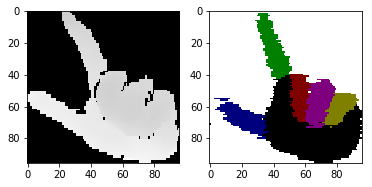

In [75]:
plt.subplot(1, 2, 1)
ran_ind = np.random.choice(range(int(x_test.shape[0])), 1)[0]
plt.imshow(x_test[ran_ind, :, :, 0], cmap='gray')

plt.subplot(1, 2, 2)
segnet_out = autoencoder.predict(np.expand_dims(np.expand_dims(x_test[ran_ind, :, :, 0], axis=0), axis=3))
segnet_rgb = class_to_rgb(np.argmax(segnet_out.reshape(96, 96, 7), axis=2))
plt.imshow(segnet_rgb)

plt.show()